# Multiple Linear Regression

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [37]:
from sklearn.preprocessing import FunctionTransformer, PowerTransformer
from sklearn.pipeline import Pipeline

### 1. Understanding the dataset

In [38]:
housing = pd.read_csv('data/housing.csv')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### 2. Train Test Split

In [39]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [40]:
housing['median_income'].min(), housing['median_income'].max()

(np.float64(0.4999), np.float64(15.0001))

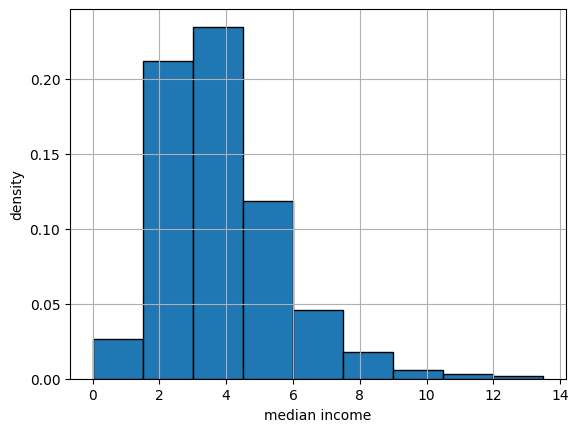

In [41]:
housing['median_income'].hist(density=True, edgecolor='black', bins=np.arange(0, 15, 1.5))
plt.xlabel("median income")
plt.ylabel('density')
plt.show()

In [42]:
income_cat = pd.cut(housing['median_income'], bins=[0, 1.5, 3.0, 4.5, 6, np.inf], labels=[1, 2, 3, 4, 5])
income_cat[:5]

0    5
1    5
2    5
3    4
4    3
Name: median_income, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [43]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_ix, test_ix in split.split(housing, income_cat):
    strat_train_set = housing.loc[train_ix]
    strat_test_set = housing.loc[test_ix]

In [44]:
strat_train_set.shape, strat_test_set.shape

((16512, 10), (4128, 10))

In [45]:
income_cat.loc[strat_train_set.index].value_counts() / len(strat_train_set)

median_income
3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: count, dtype: float64

In [46]:
income_cat.loc[strat_test_set.index].value_counts() / len(strat_test_set)

median_income
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

### 3. Data Exploration

In [47]:
strat_train_set.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.575635,35.639314,28.653404,2622.539789,534.914639,1419.687379,497.011810,3.875884,207005.322372
std,2.001828,2.137963,12.574819,2138.417080,412.665649,1115.663036,375.696156,1.904931,115701.297250
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566950,119800.000000
50%,-118.510000,34.260000,29.000000,2119.000000,433.000000,1164.000000,408.000000,3.541550,179500.000000
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.000000,602.000000,4.745325,263900.000000
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000


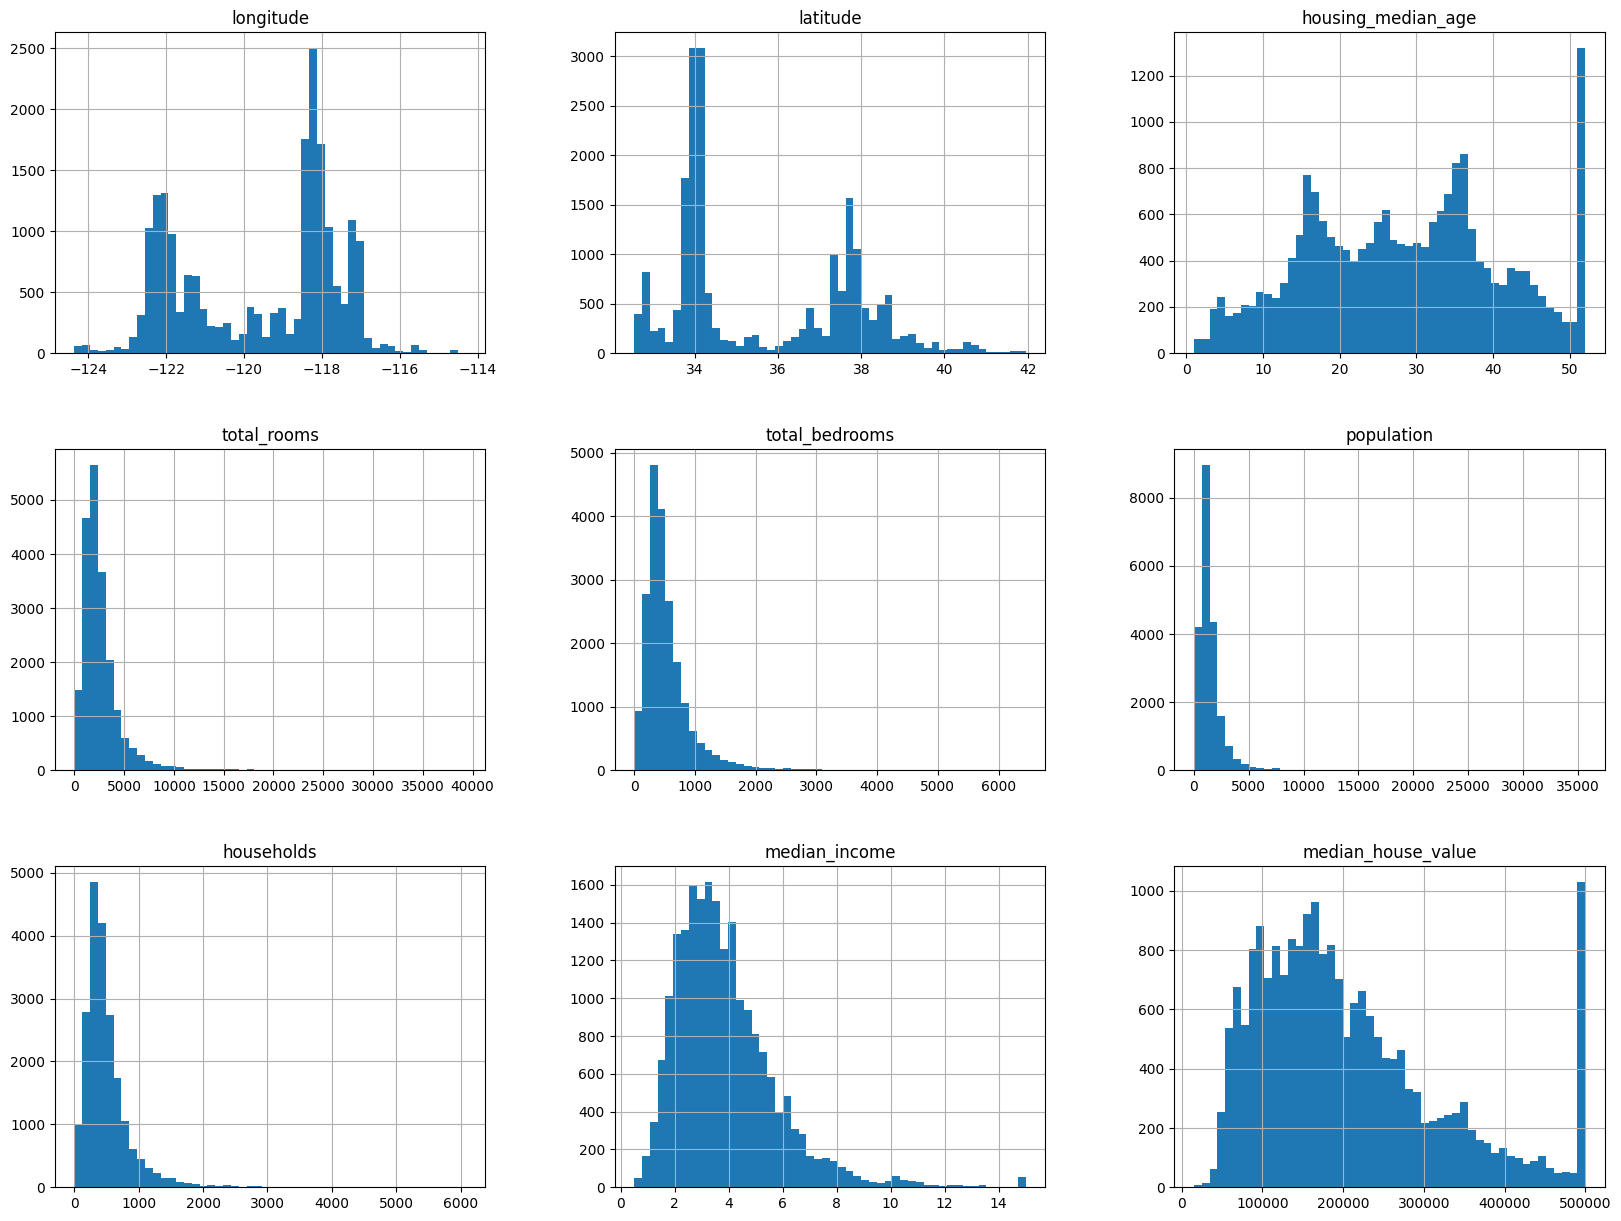

In [48]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

Check each individual features and see if you find something unusual. For eg: 
- Why the median income is not in dollars? (because they are scaled by dividing by 10,000 dollars and capped at 15 and 0.5)
- Why the median age and median house value has a upper bound? (the house values are capped at values greater than 500000 dollars)
- Many histograms are tail heavy.
- Features are at different scale

### Visualizing Geographical Data

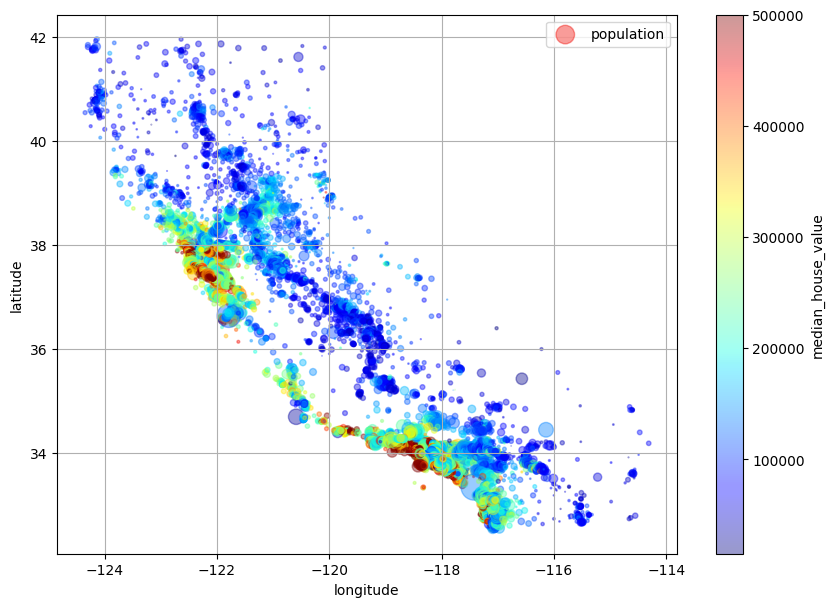

In [49]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, s=housing['population']/100, label='population', figsize=(10, 7), 
            c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()
plt.grid()
plt.show()

### Looking for Correlations

In [50]:
num_cols = housing.columns[housing.dtypes != 'object']
cat_cols = housing.columns[housing.dtypes == 'object']

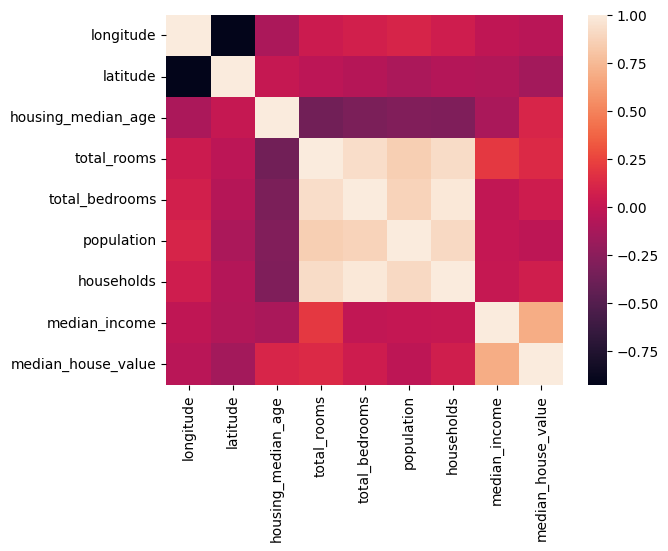

In [51]:
corr_matrix = housing[num_cols].corr()
sns.heatmap(corr_matrix)
plt.show()

In [52]:
corr = corr_matrix['median_house_value'].sort_values(ascending=False)
corr

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

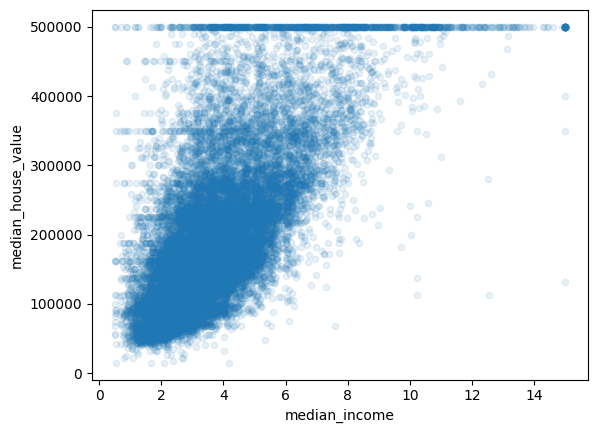

In [53]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)
plt.show()

Do you see any interesting pattern in this plot? 

### Combine different attributes together

In [54]:
df = pd.DataFrame({'rooms_per_household': housing['total_rooms'] / housing['households'],
             'bedrooms_per_room':  housing['total_bedrooms'] / housing['total_rooms'],
             'population_per_household': housing['population'] / housing['households'],
            'median_house_value': housing['median_house_value']
            })
df.corr()['median_house_value']

rooms_per_household         0.151948
bedrooms_per_room          -0.255880
population_per_household   -0.023737
median_house_value          1.000000
Name: median_house_value, dtype: float64

In [55]:
corr[['total_rooms', 'total_bedrooms', 'population']]

total_rooms       0.134153
total_bedrooms    0.049686
population       -0.024650
Name: median_house_value, dtype: float64

The new features `bedrooms_per_room` attribute is much more correlated with the median house value than the total number of rooms or bedrooms. Similarly, the number of rooms per household is also more informative than the total number of rooms in a district. 

### Handling missing values

In [56]:
housing.isnull().any()

longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms         True
population            False
households            False
median_income         False
median_house_value    False
ocean_proximity       False
dtype: bool

In [57]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

imputer.fit(strat_train_set[['total_bedrooms']])

SimpleImputer(strategy='median')

In [58]:
imputer.statistics_

array([433.])

In [59]:
X = imputer.transform(strat_train_set[['total_bedrooms']])
X

array([[797.],
       [855.],
       [310.],
       ...,
       [166.],
       [580.],
       [222.]], shape=(16512, 1))

### Handling Text and Categorical Attributes

In [60]:
housing[cat_cols].head()

,ocean_proximity
0,NEAR BAY
1,NEAR BAY
2,NEAR BAY
3,NEAR BAY
4,NEAR BAY


In [61]:
housing[cat_cols].value_counts()

ocean_proximity
<1H OCEAN          9136
INLAND             6551
NEAR OCEAN         2658
NEAR BAY           2290
ISLAND                5
Name: count, dtype: int64

In [62]:
ordinal_encoder.categories_

NameError: name 'ordinal_encoder' is not defined

In [63]:
ordinal_encoder.transform(housing[['ocean_proximity']])

NameError: name 'ordinal_encoder' is not defined

In [66]:
housing['ocean_proximity']

0        NEAR BAY
1        NEAR BAY
2        NEAR BAY
3        NEAR BAY
4        NEAR BAY
           ...   
20635      INLAND
20636      INLAND
20637      INLAND
20638      INLAND
20639      INLAND
Name: ocean_proximity, Length: 20640, dtype: object

In [67]:
mapping = {'ISLAND': 5, 'NEAR BAY': 4, 'NEAR OCEAN': 3, '<1H OCEAN': 2, 'INLAND': 1}

def ordinal_encoder(X):
    return np.array(np.expand_dims(X.map(mapping), axis=1))

In [68]:
ordinal_encoder(strat_train_set['ocean_proximity'])

array([[1],
       [3],
       [1],
       ...,
       [2],
       [2],
       [1]], shape=(16512, 1))

array([[<Axes: title={'center': 'total_rooms'}>]], dtype=object)

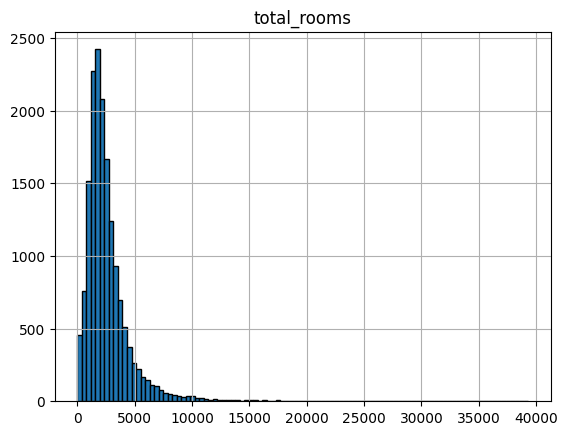

In [69]:
strat_train_set[['total_rooms']].hist(bins=100, edgecolor='black')

#### Log Transformation

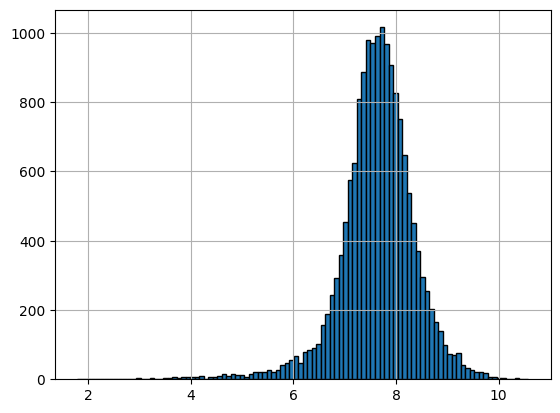

In [70]:
plt.hist(np.log(strat_train_set['total_rooms']), bins=100, edgecolor='black')
plt.grid()
plt.show()

#### Box-Cox Transformation

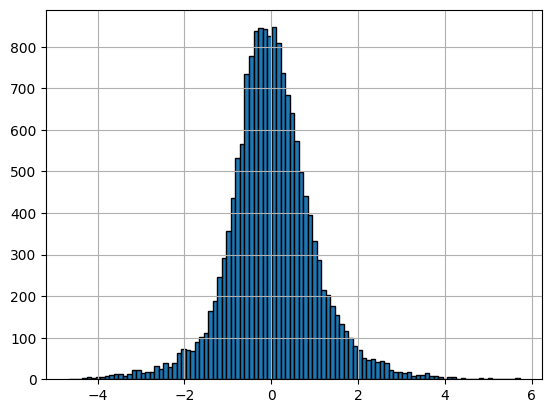

In [71]:
pt = PowerTransformer(method='box-cox')
total_rooms_scaled = pt.fit_transform(strat_train_set[['total_rooms']])
plt.hist(total_rooms_scaled.flatten(), bins=100, edgecolor='black')
plt.grid()
plt.show()

### Putting it all together

In [72]:
median_income_mask = np.logical_or(housing['median_income'] < 15, housing['median_income'] > 0.5)
median_age_mask = housing['housing_median_age'] != 52
median_housevalue_mask = np.logical_or(housing['median_house_value'] < 500000, housing['median_house_value'] > 15000)

housing_df = housing[median_income_mask & median_age_mask & median_housevalue_mask]
housing_df.shape

(19367, 10)

In [73]:
income_cat = pd.cut(housing_df['median_income'], bins=[0, 1.5, 3.0, 4.5, 6, np.inf], labels=[1, 2, 3, 4, 5])

In [74]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_ix, test_ix in split.split(housing_df, income_cat):
    strat_train_set = housing.loc[train_ix]
    strat_test_set = housing.loc[test_ix]

In [75]:
def add_feature(X):
    return np.expand_dims(X[:, 0] / X[:, 1], axis = 1)

In [76]:
from sklearn.compose import ColumnTransformer

In [77]:
feature_adder = ColumnTransformer([
                                    ('keep', 'passthrough', [0, 1, 2, 3, 4, 5, 6, 7, 8]),
                                    ('rooms_per_household', FunctionTransformer(add_feature, validate=True), [3, 6]),
                                    ('bedrooms_per_room', FunctionTransformer(add_feature, validate=True), [4, 3]),
                                ])

In [78]:
X = feature_adder.fit_transform(strat_train_set[strat_train_set.notna().all(axis=1)][num_cols])
X.shape

(15349, 11)

In [79]:
strat_train_set.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [80]:
steps = [
    ('imputer', SimpleImputer(strategy='mean')),
    ('add_new_features', feature_adder),
    ('transform', PowerTransformer(method='yeo-johnson'))
]

num_pipeline = Pipeline(steps)

train_X_num = num_pipeline.fit_transform(strat_train_set[num_cols])

In [81]:
from sklearn.base import BaseEstimator, TransformerMixin

class OrdinalEncoderAdder(BaseEstimator, TransformerMixin):
    def __init__(self, ordinal_encoder = True):
        self.ordinal_encoder = ordinal_encoder
        self.mapping = {'ISLAND': 5, 'NEAR BAY': 4, 'NEAR OCEAN': 3, '<1H OCEAN': 2, 'INLAND': 1}

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_series = pd.Series(X)
        return np.array(np.expand_dims(X_series.map(mapping), axis = 1))

In [82]:
steps = [
            ('ordinal_encoder', OrdinalEncoderAdder()),
        ]

cat_pipeline = Pipeline(steps)
train_X_cat = cat_pipeline.fit_transform(strat_train_set['ocean_proximity'])

In [83]:
train_X = np.c_[train_X_num, train_X_cat]
train_X

array([[-2.27595720e-15,  1.08196377e+00, -8.35853744e-01, ...,
        -6.47706865e-01,  1.03874101e+00,  4.00000000e+00],
       [-1.80411242e-15,  6.90657032e-01, -2.62589755e-02, ...,
        -7.08733648e-01,  9.30462511e-01,  2.00000000e+00],
       [ 1.99840144e-15, -1.58252878e+00, -2.62589755e-02, ...,
         3.57479874e-01, -6.80179117e-01,  3.00000000e+00],
       ...,
       [-1.49880108e-15,  1.35158571e+00, -1.72488651e+00, ...,
         1.23655871e-01,  1.31650849e-01,  1.00000000e+00],
       [ 9.99200722e-16, -7.36209745e-01,  8.85076454e-01, ...,
         1.73869951e-01, -1.70176911e-01,  2.00000000e+00],
       [-2.69229083e-15,  1.27229893e+00, -1.00557424e+00, ...,
         5.78102497e-01, -4.68820373e-01,  2.00000000e+00]],
      shape=(15493, 12))

In [84]:
train_X.shape

(15493, 12)

In [85]:
def standardize(X): 
    return (X - np.mean(X)) / np.std(X)

In [86]:
train_y = strat_train_set['median_house_value']
train_y.shape

(15493,)

In [87]:
test_X = np.c_[num_pipeline.transform(strat_test_set[num_cols]), cat_pipeline.fit_transform(strat_test_set['ocean_proximity'])]
test_X.shape

(3874, 12)

In [88]:
test_y = strat_test_set['median_house_value']

In [89]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(train_X, train_y)

LinearRegression()

In [90]:
y_pred = lin_reg.predict(test_X)
y_pred

array([144068.37711917, 126517.12135539, 237952.05054405, ...,
       248139.10566975, 219338.72249156, 300857.41484471], shape=(3874,))

In [91]:
from sklearn.metrics import mean_squared_error

lin_mse = mean_squared_error(test_y, y_pred)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

np.float64(30221.30355878032)

In [92]:
train_X.shape

(15493, 12)

### Cross-validation

#### Hyperparameter tuning

In [93]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [94]:
param_grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
              {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
              
             ]

In [95]:
forest_reg = RandomForestRegressor()

In [96]:
forest_reg.fit(train_X, train_y)

RandomForestRegressor()

In [97]:
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

In [99]:
grid_search.fit(train_X, train_y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             scoring='neg_mean_squared_error')

In [100]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

30536.320304325945 {'max_features': 2, 'n_estimators': 3}
19269.604271499542 {'max_features': 2, 'n_estimators': 10}
16393.17665714127 {'max_features': 2, 'n_estimators': 30}
12164.021697988273 {'max_features': 4, 'n_estimators': 3}
7922.127971211391 {'max_features': 4, 'n_estimators': 10}
5484.456759226974 {'max_features': 4, 'n_estimators': 30}
7527.28783768555 {'max_features': 6, 'n_estimators': 3}
3138.2090220614655 {'max_features': 6, 'n_estimators': 10}
2272.3609664407572 {'max_features': 6, 'n_estimators': 30}
3286.6903919670112 {'max_features': 8, 'n_estimators': 3}
1803.3722472619124 {'max_features': 8, 'n_estimators': 10}
949.3163668220795 {'max_features': 8, 'n_estimators': 30}
25754.054072671697 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
18347.331745326424 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
16615.00801092759 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
10576.459755655005 {'bootstrap': False, 'max_features': 3, 'n_estima

In [101]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([1.43344092e-03, 1.30882297e-03, 6.32044525e-04, 9.53318330e-05,
       1.63750195e-04, 1.51497363e-04, 1.05371937e-04, 1.04855348e-01,
       8.48242439e-01, 4.84298031e-03, 6.12816969e-03, 3.20408032e-02])

In [102]:
train_X.shape

(15493, 12)